In [1]:
%%capture

!pip install flowpy

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import tensorflow as tf
import flowpy
import struct
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
from skimage.transform import resize
from skimage.io import imread
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (Layer, Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer,
                                     BatchNormalization, Input, GlobalAvgPool2D, PReLU)

## Parameter Configuration

In [3]:
BATCH_SIZE = 16
LQ_IMAGE_SHAPE = (64, 64, 3)
HQ_IMAGE_SHAPE = (256, 256, 3)
B=16
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Data Preparation

In [4]:
# Check if the dataset directory exists before unzipping
if not os.path.exists('/content/dataset'):
    !mkdir /content/dataset

!unzip -q '/content/drive/MyDrive/Colab Notebooks/Projects/PIV SRGAN Analysis/DNS_turbulence.zip' -d '/content/dataset/'

In [5]:
def convert_tif_to_png(source_dir, target_dir):
    """
    Convert all .tif images in the source directory to .png format and save them in the target directory.

    Args:
    source_dir (str): Directory containing the original .tif files.
    target_dir (str): Directory where the converted .png files will be saved.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in os.listdir(source_dir):
        if file_name.endswith('.tif'):
            file_path = os.path.join(source_dir, file_name)
            image = Image.open(file_path)
            png_file_name = os.path.splitext(file_name)[0] + '.png'
            png_file_path = os.path.join(target_dir, png_file_name)
            image.save(png_file_path, 'PNG')
            print(f'Converted {file_name} to {png_file_name}')

In [6]:
%%capture

source_dir = '/content/dataset/DNS_turbulence'
target_dir = '/content/dataset/DNS_turbulence_pngs'
convert_tif_to_png(source_dir, target_dir)

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(target_dir, label_mode=None, batch_size=BATCH_SIZE)

Found 4000 files belonging to 1 classes.


In [8]:
def preprocess_and_augment(image):
    angles = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=angles)

    # Normalize the image to the range [-1, 1]
    image_lq = tf.image.resize(image, [LQ_IMAGE_SHAPE[0], LQ_IMAGE_SHAPE[1]], method='bicubic')

    # Previously calculated min and max values:
    image_lq_min_val = -28.71875
    image_lq_max_val = 312.79297

    image_lq = (2 * (image_lq - image_lq_min_val) / (image_lq_max_val - image_lq_min_val)) - 1.0
    image_hq = tf.cast(image, tf.float32) / 127.5 - 1.0

    return image_lq, image_hq

In [9]:
train_dataset = (dataset
                 .map(preprocess_and_augment)
                 .unbatch()
                 .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                 .batch(BATCH_SIZE, drop_remainder=True)
                 .prefetch(AUTOTUNE))

In [10]:
for lr_images, hr_images in train_dataset.take(1):
    # Print the shapes to verify the dataset
    print("Low-resolution images shape:", lr_images.shape)
    print("High-resolution images shape:", hr_images.shape)

    # Check the range of pixel values
    print("Low-resolution images - min value:", tf.reduce_min(lr_images).numpy())
    print("Low-resolution images - max value:", tf.reduce_max(lr_images).numpy())
    print("High-resolution images - min value:", tf.reduce_min(hr_images).numpy())
    print("High-resolution images - max value:", tf.reduce_max(hr_images).numpy())

    # Optional: print a few pixel values to inspect
    print("\nLow-resolution image sample pixel values:\n", lr_images[0, :3, :3, :])  # First image, top-left 3x3 pixels
    print("\nHigh-resolution image sample pixel values:\n", hr_images[0, :3, :3, :])  # First image, top-left 3x3 pixels

Low-resolution images shape: (16, 64, 64, 3)
High-resolution images shape: (16, 256, 256, 3)
Low-resolution images - min value: -0.9563522
Low-resolution images - max value: 0.9389663
High-resolution images - min value: -1.0
High-resolution images - max value: 1.0

Low-resolution image sample pixel values:
 tf.Tensor(
[[[-0.8317911  -0.8317911  -0.8317911 ]
  [-0.7476523  -0.7476523  -0.7476523 ]
  [-0.81383324 -0.81383324 -0.81383324]]

 [[-0.80026764 -0.80026764 -0.80026764]
  [-0.38481247 -0.38481247 -0.38481247]
  [-0.25107807 -0.25107807 -0.25107807]]

 [[ 0.28495777  0.28495777  0.28495777]
  [-0.834216   -0.834216   -0.834216  ]
  [-0.6248528  -0.6248528  -0.6248528 ]]], shape=(3, 3, 3), dtype=float32)

High-resolution image sample pixel values:
 tf.Tensor(
[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]], shape=(3, 3, 3), dtype=float32)


In [11]:
def visualize_images(lr_images, hr_images, n=1):
    """
    Visualizes low-resolution and high-resolution images side by side.

    Parameters:
    lr_images (numpy array): Array of low-resolution images.
    hr_images (numpy array): Array of high-resolution images.
    n (int): Number of images to visualize. Default is 1.
    """
    plt.figure(figsize=(12, 12), dpi=220)

    for i in range(n):
        # First row: Low-resolution images
        ax1 = plt.subplot(n, 3, i * 3 + 1)
        plt.imshow((lr_images[i] + 1) / 2)
        plt.title("Low-resolution")
        plt.axis("off")

        # Second row: Rescaled low-resolution images
        ax2 = plt.subplot(n, 3, i * 3 + 2)
        resized_image = cv2.resize(np.array(lr_images[i]), (256, 256))
        plt.imshow((resized_image + 1) / 2)
        plt.title("Rescaled via (cv2.resize)")
        plt.axis("off")

        # Third row: High-resolution images
        ax3 = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow((hr_images[i] + 1) / 2)
        plt.title("High-resolution")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

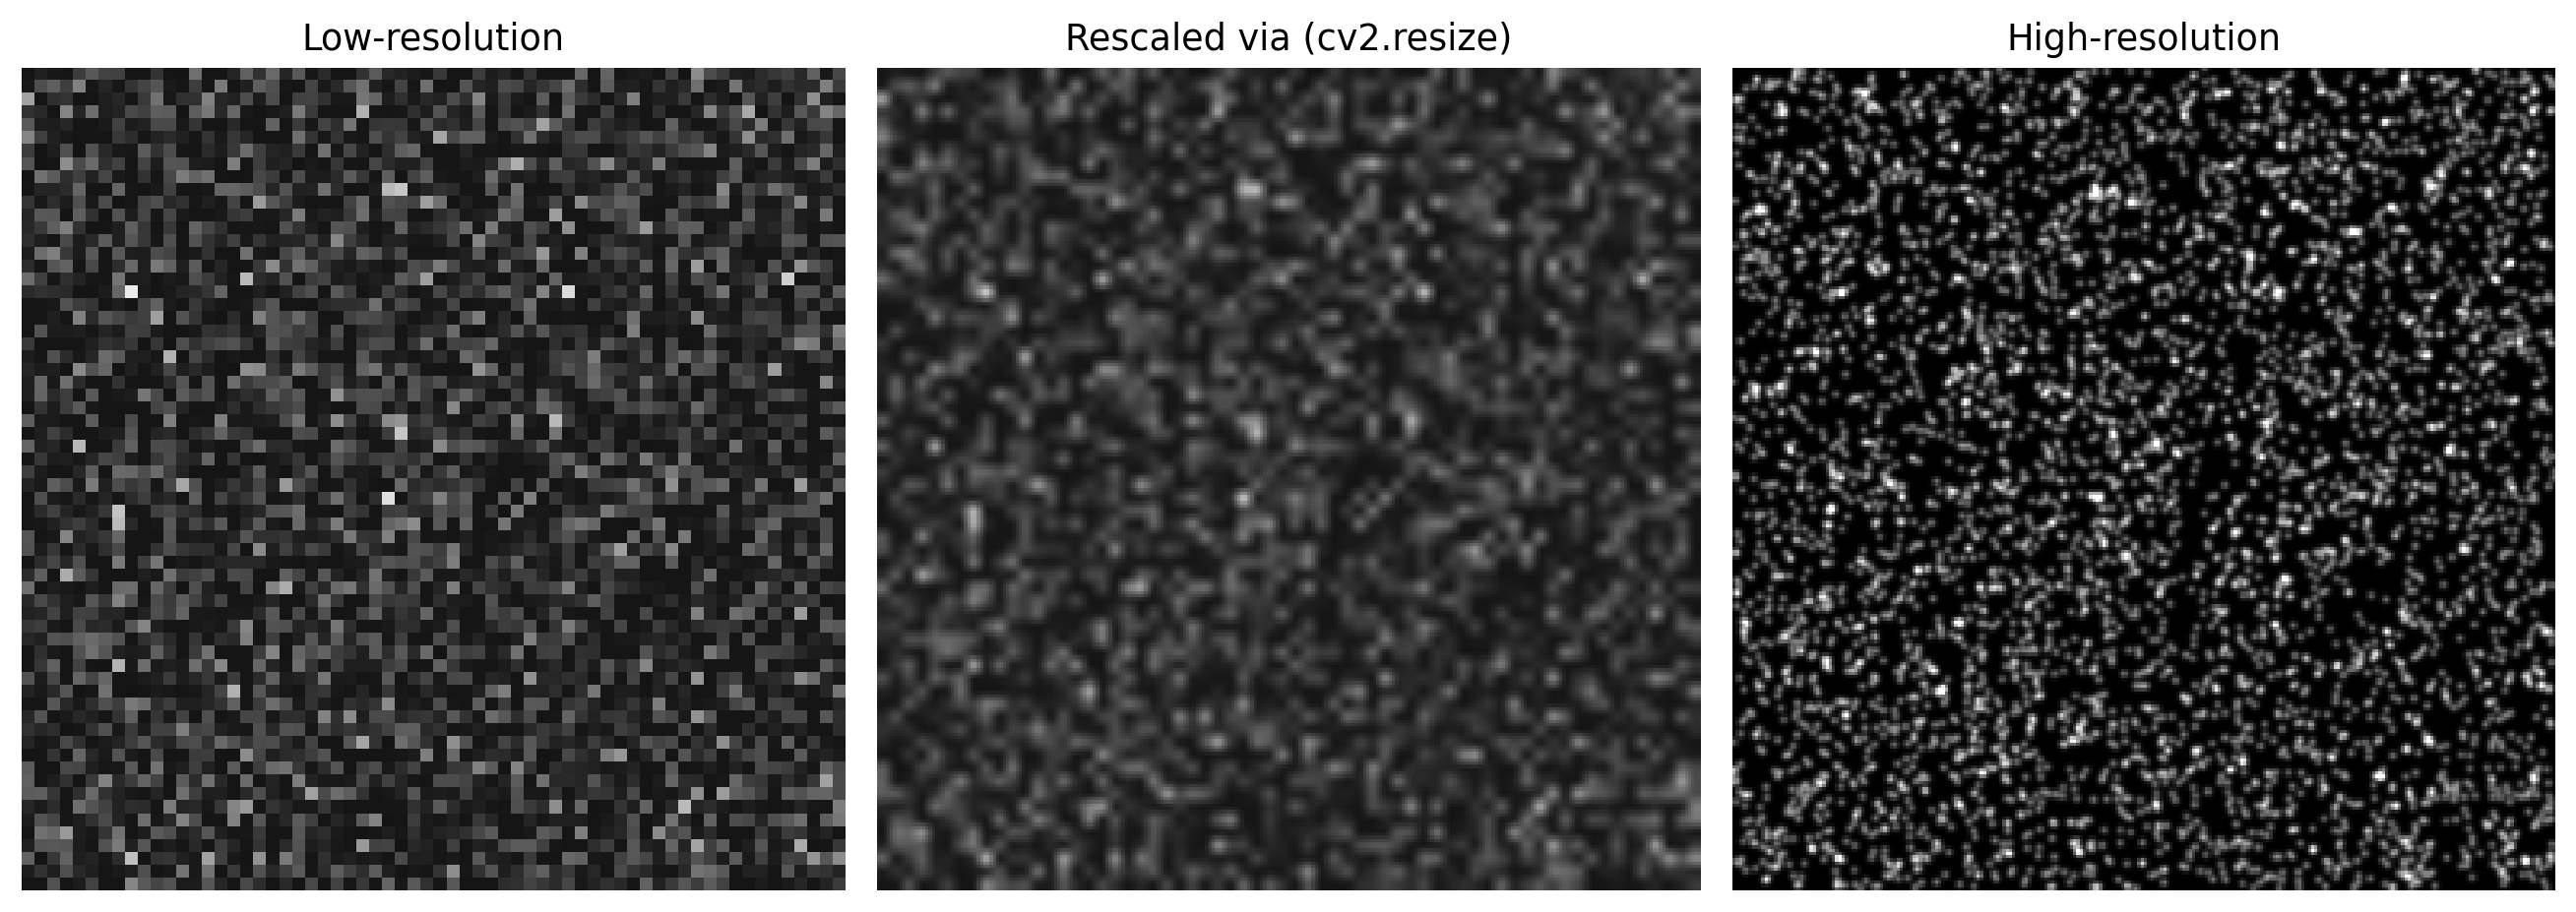

In [12]:
visualize_images(lr_images, hr_images)

## Visualization

In [13]:
class FlowVisualizer:
    """
    A class for visualizing optical flow data from .flo files using various color schemes.

    Methods
    -------
    read_flo_file(file_path):
        Reads an optical flow file in Middlebury .flo format.

    flow_to_hsv(flow, max_flow=None):
        Converts flow data to a 3-channel color image using the HSV color space.

    flow_to_jet(flow, max_flow=None):
        Converts flow data to a 3-channel color image using the jet colormap.

    flow_to_plasma(flow, max_flow=None):
        Converts flow data to a 3-channel color image using the plasma colormap.

    visualize_flows(flow_dir, num_images=9, color_scheme='jet'):
        Visualizes a number of flow images from a directory with optional color schemes and streamlines.
    """
    def __init__(self):
        pass

    def read_flo_file(self, file_path):
        """
        Reads an optical flow file in Middlebury .flo format.

        Parameters:
        file_path (str): The path to the .flo file.

        Returns:
        np.ndarray: The flow data as a (height, width, 2) numpy array.
        """
        with open(file_path, 'rb') as f:
            magic = np.fromfile(f, np.float32, count=1)
            if magic != 202021.25:
                raise ValueError('Magic number incorrect. Invalid .flo file')

            width = np.fromfile(f, np.int32, count=1)[0]
            height = np.fromfile(f, np.int32, count=1)[0]
            flow = np.fromfile(f, np.float32, count=2*width*height)
            flow = np.resize(flow, (height, width, 2))

        return flow

    def flow_to_hsv(self, flow, max_flow=None):
        """
        Converts flow data to a 3-channel color image using the HSV color space.

        Parameters:
        flow (np.ndarray): The optical flow data.
        max_flow (float, optional): The maximum flow value for normalization. Default is None.

        Returns:
        np.ndarray: The flow data as a color image in HSV color space.
        """
        if max_flow is not None:
            norm_flow = np.linalg.norm(flow, axis=2)
            flow[norm_flow > max_flow] = max_flow * flow[norm_flow > max_flow] / norm_flow[norm_flow > max_flow][..., None]

        hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
        hsv[..., 1] = 255

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

        flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return flow_rgb

    def flow_to_jet(self, flow, max_flow=None):
        """
        Converts flow data to a 3-channel color image using the jet colormap.

        Parameters:
        flow (np.ndarray): The optical flow data.
        max_flow (float, optional): The maximum flow value for normalization. Default is None.

        Returns:
        np.ndarray: The flow data as a color image in jet colormap.
        """
        if max_flow is not None:
            norm_flow = np.linalg.norm(flow, axis=2)
            flow[norm_flow > max_flow] = max_flow * flow[norm_flow > max_flow] / norm_flow[norm_flow > max_flow][..., None]

        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag_normalized = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        flow_rgb = cv2.applyColorMap(mag_normalized, cv2.COLORMAP_JET)
        return flow_rgb

    def flow_to_plasma(self, flow, max_flow=None):
        """
        Converts flow data to a 3-channel color image using the plasma colormap.

        Parameters:
        flow (np.ndarray): The optical flow data.
        max_flow (float, optional): The maximum flow value for normalization. Default is None.

        Returns:
        np.ndarray: The flow data as a color image in plasma colormap.
        """
        if max_flow is not None:
            norm_flow = np.linalg.norm(flow, axis=2)
            flow[norm_flow > max_flow] = max_flow * flow[norm_flow > max_flow] / norm_flow[norm_flow > max_flow][..., None]

        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag_normalized = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        flow_rgb = cv2.applyColorMap(mag_normalized, cv2.COLORMAP_PLASMA)
        return flow_rgb

    def visualize_flows(self, flow_dir, num_images=9, color_scheme='jet'):
        """
        Visualizes a number of flow images from a directory with optional color schemes and streamlines.

        Parameters:
        flow_dir (str): The directory containing .flo files.
        num_images (int, optional): The number of images to visualize. Default is 9.
        color_scheme (str, optional): The color scheme to use ('jet', 'plasma', 'hsv'). Default is 'jet'.
        """
        flow_files = [os.path.join(flow_dir, f) for f in os.listdir(flow_dir) if f.endswith('.flo')]
        selected_files = flow_files[:num_images]

        plt.figure(figsize=(12, 12))
        for i, file in enumerate(selected_files):
            flow = self.read_flo_file(file)

            if color_scheme == 'jet':
                flow_img = self.flow_to_jet(flow)
            elif color_scheme == 'plasma':
                flow_img = self.flow_to_plasma(flow)
            elif color_scheme == 'hsv':
                flow_img = self.flow_to_hsv(flow)

            plt.subplot(3, 3, i + 1)
            plt.imshow(flow_img, origin='lower')

            # Add streamlines
            X, Y = np.meshgrid(np.arange(flow.shape[1]), np.arange(flow.shape[0]))
            U = flow[..., 0]
            V = flow[..., 1]
            plt.streamplot(X, Y, U, V, color='w', linewidth=0.5, density=1.5)

            plt.title(os.path.basename(file))
            plt.axis('off')
        plt.tight_layout()
        plt.show()

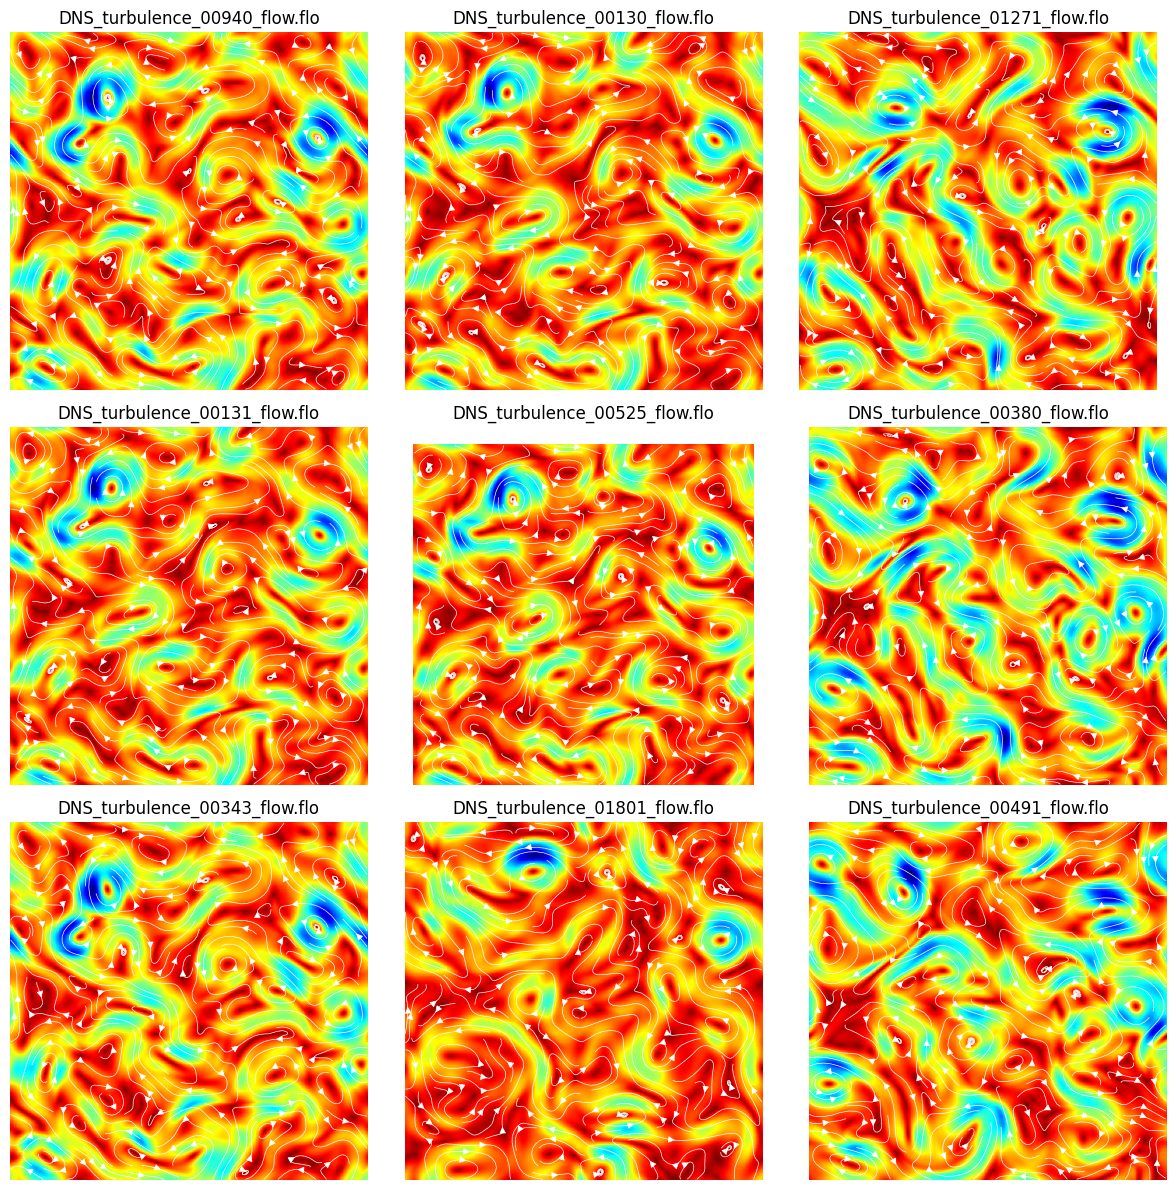

In [14]:
flow_dir = '/content/dataset/DNS_turbulence'
visualizer = FlowVisualizer()
visualizer.visualize_flows(flow_dir)

## Modeling

### Generator

In [15]:
class ResBlock(Layer):
    """
    A Residual Block Layer for Convolutional Neural Networks.

    This class implements a residual block, which consists of two convolutional
    layers each followed by batch normalization and a PReLU activation. The
    output of the block is the sum of the input and the processed input, creating
    a residual connection that helps with gradient flow during training.

    Parameters:
    ----------
    n_filters : int
        Number of filters for the convolutional layers.
    filter_size : int or tuple of int
        Size of the convolutional filters.
    strides : int or tuple of int
        Stride size for the convolutional layers.
    name : str, optional
        Name for the layer (default is 'res_block').

    Methods:
    -------
    build(input_shape)
        Builds the layers of the residual block.
    call(inputs)
        Executes the forward pass of the residual block.
    """

    def __init__(self, n_filters, filter_size, strides, name='res_block'):
        super(ResBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        self.conv_1 = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm_1 = BatchNormalization()
        self.prelu = PReLU()
        self.conv_2 = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm_2 = BatchNormalization()

    def call(self, inputs):
        """
        Executes the forward pass of the residual block.

        Parameters:
        ----------
        inputs : tensor
            Input tensor to the residual block.

        Returns:
        -------
        tensor
            Output tensor after applying the residual block operations.
        """
        x = self.conv_1(inputs)
        x = self.prelu(self.batch_norm_1(x))
        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        return x + inputs

In [16]:
class UpsampleBlock(Layer):
    """
    Upsample Block Layer for Super-Resolution Models.

    This class implements an upsampling block, which consists of a convolutional
    layer followed by pixel shuffling (depth to space operation) and a PReLU activation.

    Parameters:
    ----------
    n_filters : int
        Number of filters for the convolutional layer.
    filter_size : int or tuple of int
        Size of the convolutional filter.
    strides : int or tuple of int
        Stride size for the convolutional layer.
    name : str, optional
        Name for the layer (default is 'upsample_block').

    Methods:
    -------
    build(input_shape)
        Builds the layers of the upsampling block.
    call(inputs)
        Executes the forward pass of the upsampling block.
    """

    def __init__(self, n_filters, filter_size, strides, name='upsample_block'):
        super(UpsampleBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        self.conv = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.prelu = PReLU()

    def call(self, inputs):
        """
        Executes the forward pass of the upsampling block.

        Parameters:
        ----------
        inputs : tensor
            Input tensor to the upsampling block.

        Returns:
        -------
        tensor
            Output tensor after applying the upsampling block operations.
        """
        x = self.conv(inputs)
        x = tf.nn.depth_to_space(x, 2)
        x = self.prelu(x)
        return x

In [17]:
# Define input layer for low-resolution images
input_lr = Input(shape=(LQ_IMAGE_SHAPE[0], LQ_IMAGE_SHAPE[1], LQ_IMAGE_SHAPE[2]))

# Initial convolutional layer
input_conv = Conv2D(64, 9, strides=1, padding='same')(input_lr)
input_conv = PReLU()(input_conv)

x = input_conv

# Residual blocks
for i in range(B):
    x = ResBlock(64, 3, 1, name=f'res_block_{i}')(x)

x = Conv2D(64, 9, padding='same')(x)
x = BatchNormalization()(x)

# Shortcut connection
x = Add()([x, input_conv])  # Adding shortcut connection to the output of the initial convolutional layer

# Upsampling blocks
x = UpsampleBlock(256, 3, 1, name='upsample_block_1')(x)
x = UpsampleBlock(256, 3, 1, name='upsample_block_2')(x)

# Output convolutional layer
output_sr = Conv2D(3, 9, activation='tanh', padding='same')(x)

# Define SRResNet model
srresnet = Model(input_lr, output_sr)

srresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 64, 64, 64)           262144    ['conv2d[0][0]']              
                                                                                                  
 res_block_0 (ResBlock)      (None, 64, 64, 64)           336512    ['p_re_lu[0][0]']             
                                                                                              

### Discriminator

In [18]:
class ConvBlock(Layer):
    def __init__(self, n_filters, filter_size, strides, name='conv_block'):
        """
        Convolutional block consisting of Conv2D and BatchNormalization layers.

        Args:
        - n_filters (int): Number of filters for Conv2D layer.
        - filter_size (int or tuple): Size of the convolutional kernel.
        - strides (int or tuple): Convolutional stride.
        - name (str): Name of the layer.

        """
        super(ConvBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        """
        Build the convolutional block.

        Args:
        - input_shape (tuple): Shape of the input tensor.

        """
        self.conv = Conv2D(
            self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm = BatchNormalization()

    def call(self, inputs):
        """
        Call method of the convolutional block.

        Args:
        - inputs (tensor): Input tensor.

        Returns:
        - Output tensor after passing through Conv2D and BatchNormalization layers.

        """
        x = self.conv(inputs)
        x = LeakyReLU()(self.batch_norm(x))
        return x

In [19]:
# Define channel numbers and stride sizes for each convolutional block
channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

# Define input layer
input_lr = Input(shape=(HQ_IMAGE_SHAPE[0], HQ_IMAGE_SHAPE[1], HQ_IMAGE_SHAPE[2]))

input_conv = Conv2D(64, 3, padding='same')(input_lr)
input_conv = LeakyReLU()(input_conv)

# Build the discriminator model
disc = input_conv
for i in range(7):
    disc = ConvBlock(channel_nums[i], 3, stride_sizes[i], name=f'conv_block_{i}')(disc)

disc = GlobalAvgPool2D()(disc)

disc = Dense(1024)(disc)
disc = LeakyReLU()(disc)

disc_output = Dense(1, activation='sigmoid')(disc)

discriminator = tf.keras.models.Model(input_lr, disc_output)

discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv_block_0 (ConvBlock)    (None, 128, 128, 64)      37184     
                                                                 
 conv_block_1 (ConvBlock)    (None, 128, 128, 128)     74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 64, 64, 128)       148096    
                                                                 
 conv_block_3 (ConvBlock)    (None, 64, 64, 256)       2961

### Loss

In [20]:
def pixel_MSE(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) between pixel values of true and predicted images.

    Parameters:
    y_true (tensor): True images.
    y_pred (tensor): Predicted images.

    Returns:
    float: Mean Squared Error (MSE) between pixel values.
    """
    return tf.reduce_mean((y_true - y_pred) ** 2)

In [21]:
# Load the VGG19 model pretrained on ImageNet
VGG19 = tf.keras.applications.VGG19(weights='imagenet',
                                    include_top=False,
                                    input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 5s 0us/step


In [22]:
def VGG_loss(y_hr, y_sr, i_m=2, j_m=2):
    """
    Calculates VGG loss between high-resolution and super-resolved images.

    Parameters:
    - y_hr (tensor): High-resolution images.
    - y_sr (tensor): Super-resolved images.
    - i_m (int): Index of the MaxPooling2D layer to stop at. Default is 2.
    - j_m (int): Index of the Conv2D layer to stop at. Default is 2.

    Returns:
    - accumulated_loss (float): Accumulated VGG loss.
    """
    i, j = 0, 0
    accumulated_loss = 0.0

    # Iterate through VGG19 layers
    for l in VGG19.layers:
        cl_name = l.__class__.__name__

        # Count Conv2D layers
        if cl_name == 'Conv2D':
            j += 1

        # Count MaxPooling2D layers and reset j
        if cl_name == 'MaxPooling2D':
            i += 1
            j = 0

        # Break when reaching the desired layer
        if i == i_m and j == j_m:
            break

        # Pass images through the current layer
        y_hr = l(y_hr)
        y_sr = l(y_sr)

        # Calculate MSE loss for Conv2D layers
        if cl_name == 'Conv2D':
            mse = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
            accumulated_loss += mse(y_hr, y_sr) * 0.006

    return accumulated_loss

In [23]:
def content_loss(y_true, y_pred):
    """
    Calculates the content loss between true and predicted images.

    The content loss is a combination of Mean Squared Error (MSE) and VGG loss.

    Parameters:
    - y_true (tensor): True high-resolution images.
    - y_pred (tensor): Predicted high-resolution images.

    Returns:
    - loss (tensor): Combined content loss.
    """
    mse = tf.keras.losses.MeanSquaredError(name='mean_squared_error')

    # Calculate MSE and VGG losses
    mse_loss = mse(y_true, y_pred)
    vgg_loss = VGG_loss(y_true, y_pred)

    # Combine loss values
    loss = mse_loss + vgg_loss

    return loss

In [24]:
class GANMonitor(tf.keras.callbacks.Callback):
    """
    Callback to generate and save images during training.

    This callback generates low-resolution images, generates corresponding
    super-resolution images using the generator model, and saves both low and
    super-resolution images every epoch.

    Attributes:
    - None
    """

    def on_epoch_end(self, epoch, logs=None, n=1):
        """
        Callback function called at the end of each epoch.

        Generates and saves low-resolution, super-resolution, and high-resolution images.

        Parameters:
        - epoch (int): Current epoch number.
        - logs (dict): Dictionary of logs containing the training loss and metrics.

        Returns:
        - None
        """
        plt.figure(figsize=(12, 12), dpi=220)

        for i in range(n):
            # First row: Low-resolution images
            ax1 = plt.subplot(n, 3, i * 3 + 1)
            plt.imshow((lr_images[i] + 1) / 2)
            plt.title("Low-resolution")
            plt.axis("off")

            # Second row: Generated images
            ax2 = plt.subplot(n, 3, i * 3 + 2)
            out = self.model.generator(tf.expand_dims(lr_images[i - 2], axis=0))
            plt.imshow((out[0] + 1) / 2)
            plt.title("Generated image")
            plt.axis("off")

            # Third row: High-resolution images
            ax3 = plt.subplot(n, 3, i * 3 + 3)
            plt.imshow((hr_images[i] + 1) / 2)
            plt.title("High-resolution")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch + 1))

### SRGAN

In [25]:
class SRGAN(tf.keras.Model):
    """
    SRGAN (Super-Resolution Generative Adversarial Network) model.

    This model consists of a discriminator and a generator. It is used for
    single-image super-resolution.

    Attributes:
    - discriminator (tf.keras.Model): Discriminator model.
    - generator (tf.keras.Model): Generator model.
    """

    def __init__(self, discriminator, generator):
        """
        Initialize SRGAN with discriminator and generator.

        Parameters:
        - discriminator (tf.keras.Model): Discriminator model.
        - generator (tf.keras.Model): Generator model.
        """
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_discriminator, loss_generator):
        """
        Compile the SRGAN model.

        Parameters:
        - d_optimizer: Optimizer for the discriminator.
        - g_optimizer: Optimizer for the generator.
        - loss_discriminator: Loss function for the discriminator.
        - loss_generator: Loss function for the generator.

        Returns:
        - None
        """
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_discriminator = loss_discriminator
        self.loss_generator = loss_generator
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        """
        Return the metrics of the SRGAN model.

        Returns:
        - List: List of metric objects.
        """
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        """
        Perform one training step.

        Parameters:
        - real_images (tuple): Tuple containing low-resolution and high-resolution images.

        Returns:
        - dict: Dictionary containing the discriminator and generator losses.
        """
        lr_images, hr_images = real_images
        batch_size = tf.shape(hr_images)[0]

        # Generate super-resolution images
        generated_images = self.generator(lr_images)

        # Labels for real and fake images
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train the discriminator
        with tf.GradientTape() as tape:
            real_predictions = self.discriminator(hr_images)
            d_loss_real = self.loss_discriminator(real_labels, real_predictions)

            fake_predictions = self.discriminator(generated_images)
            d_loss_fake = self.loss_discriminator(fake_labels, fake_predictions)

            d_loss = 0.5 * (d_loss_fake + d_loss_real)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the generator
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.generator(lr_images)
            g_loss = self.loss_generator(hr_images, predictions)
            g_loss += 1e-3 * self.loss_discriminator(misleading_labels, self.discriminator(predictions))

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [26]:
epochs = 10

srgan = SRGAN(discriminator=discriminator, generator=srresnet)
srgan.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7, beta_1=0.3),
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.3),
              loss_discriminator=tf.keras.losses.BinaryCrossentropy(),
              loss_generator=content_loss)

In [27]:
if not os.path.exists('/content/generated'):
    os.makedirs('/content/generated')
    print('Directory created.')
else:
    print('Directory already exists.')

Directory created.


Epoch 1/10
    250/Unknown - 389s 1s/step - d_loss: 0.6929 - g_loss: 0.4194

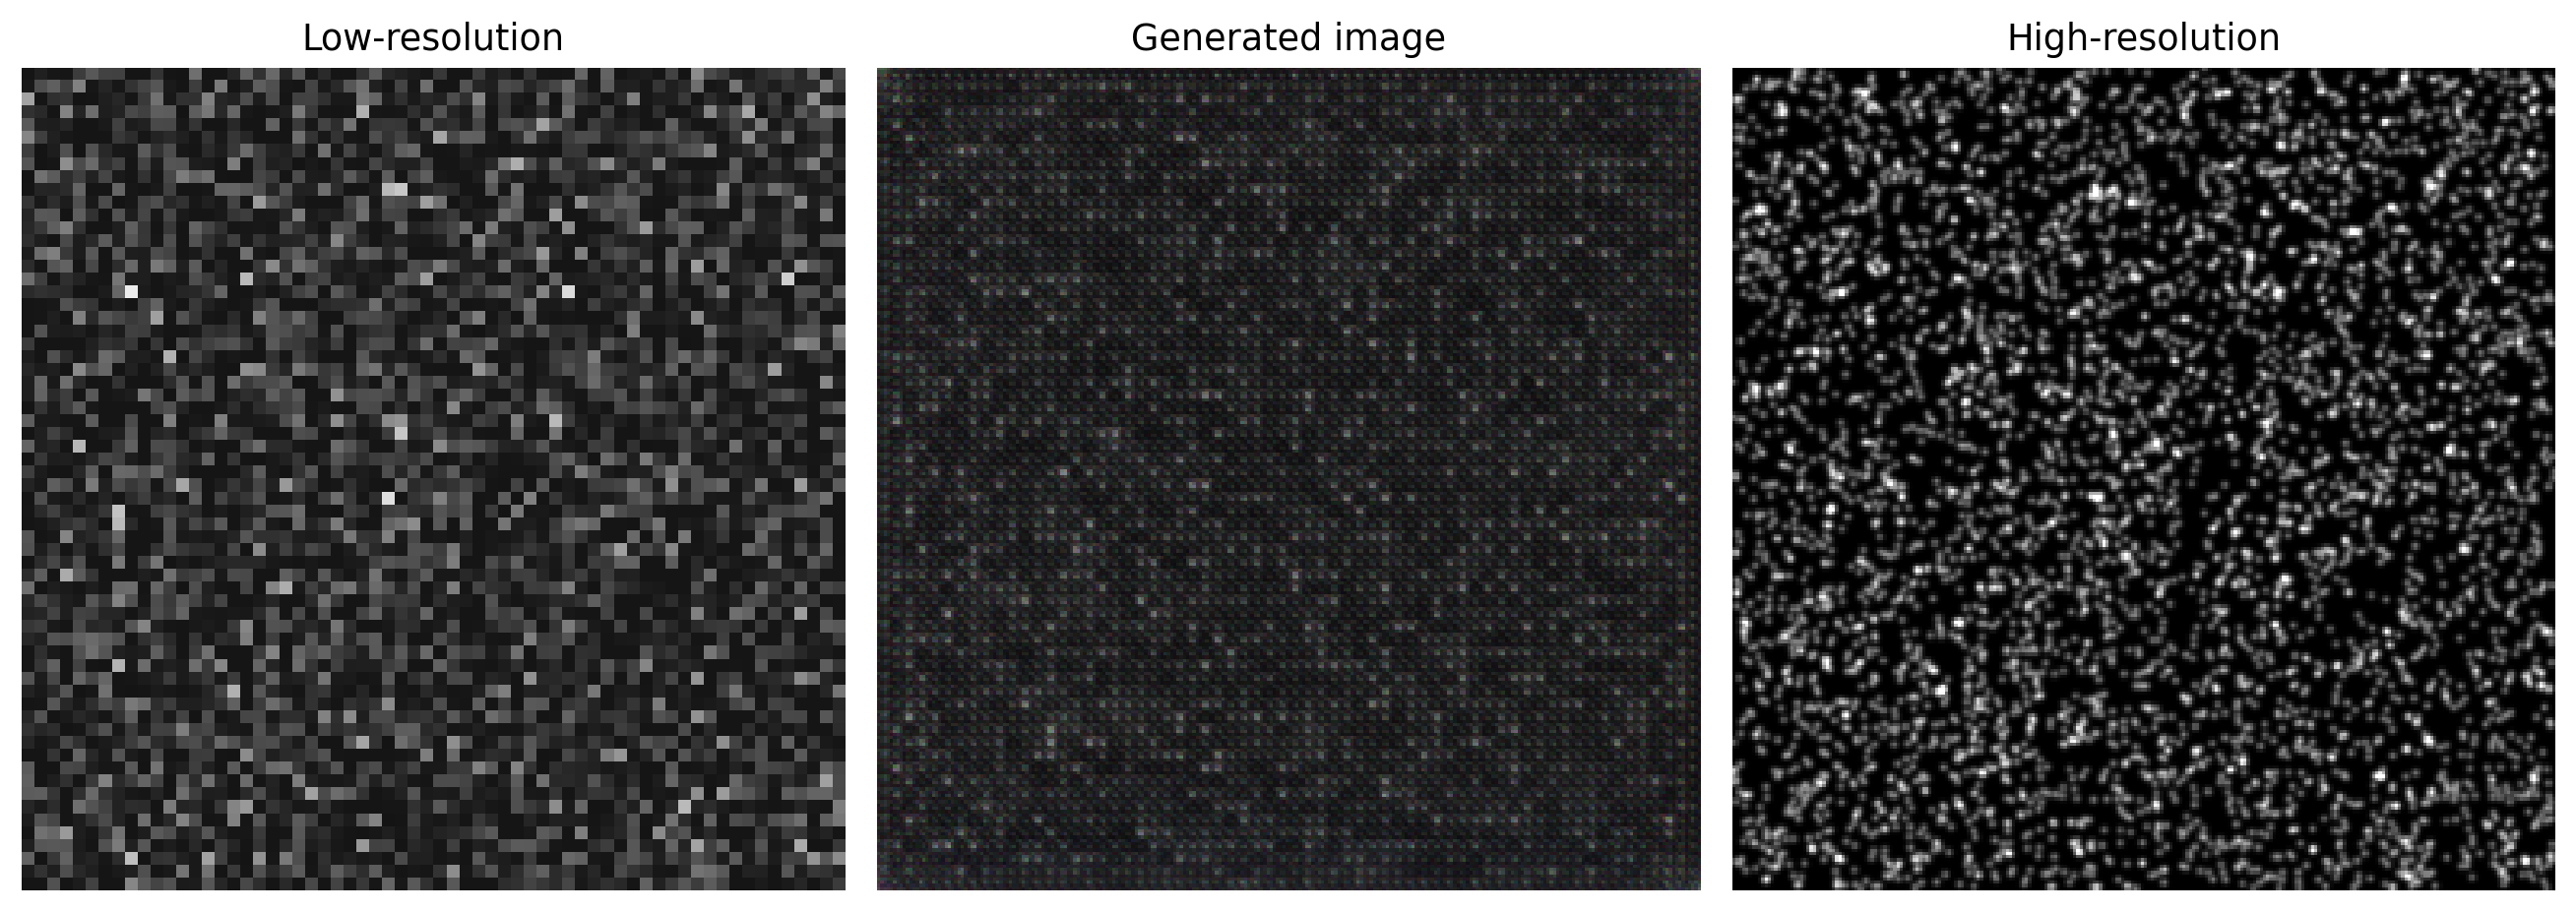

250/250 [==============================] - 391s 1s/step - d_loss: 0.6929 - g_loss: 0.4194
Epoch 2/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6917 - g_loss: 0.3611

<Figure size 640x480 with 0 Axes>

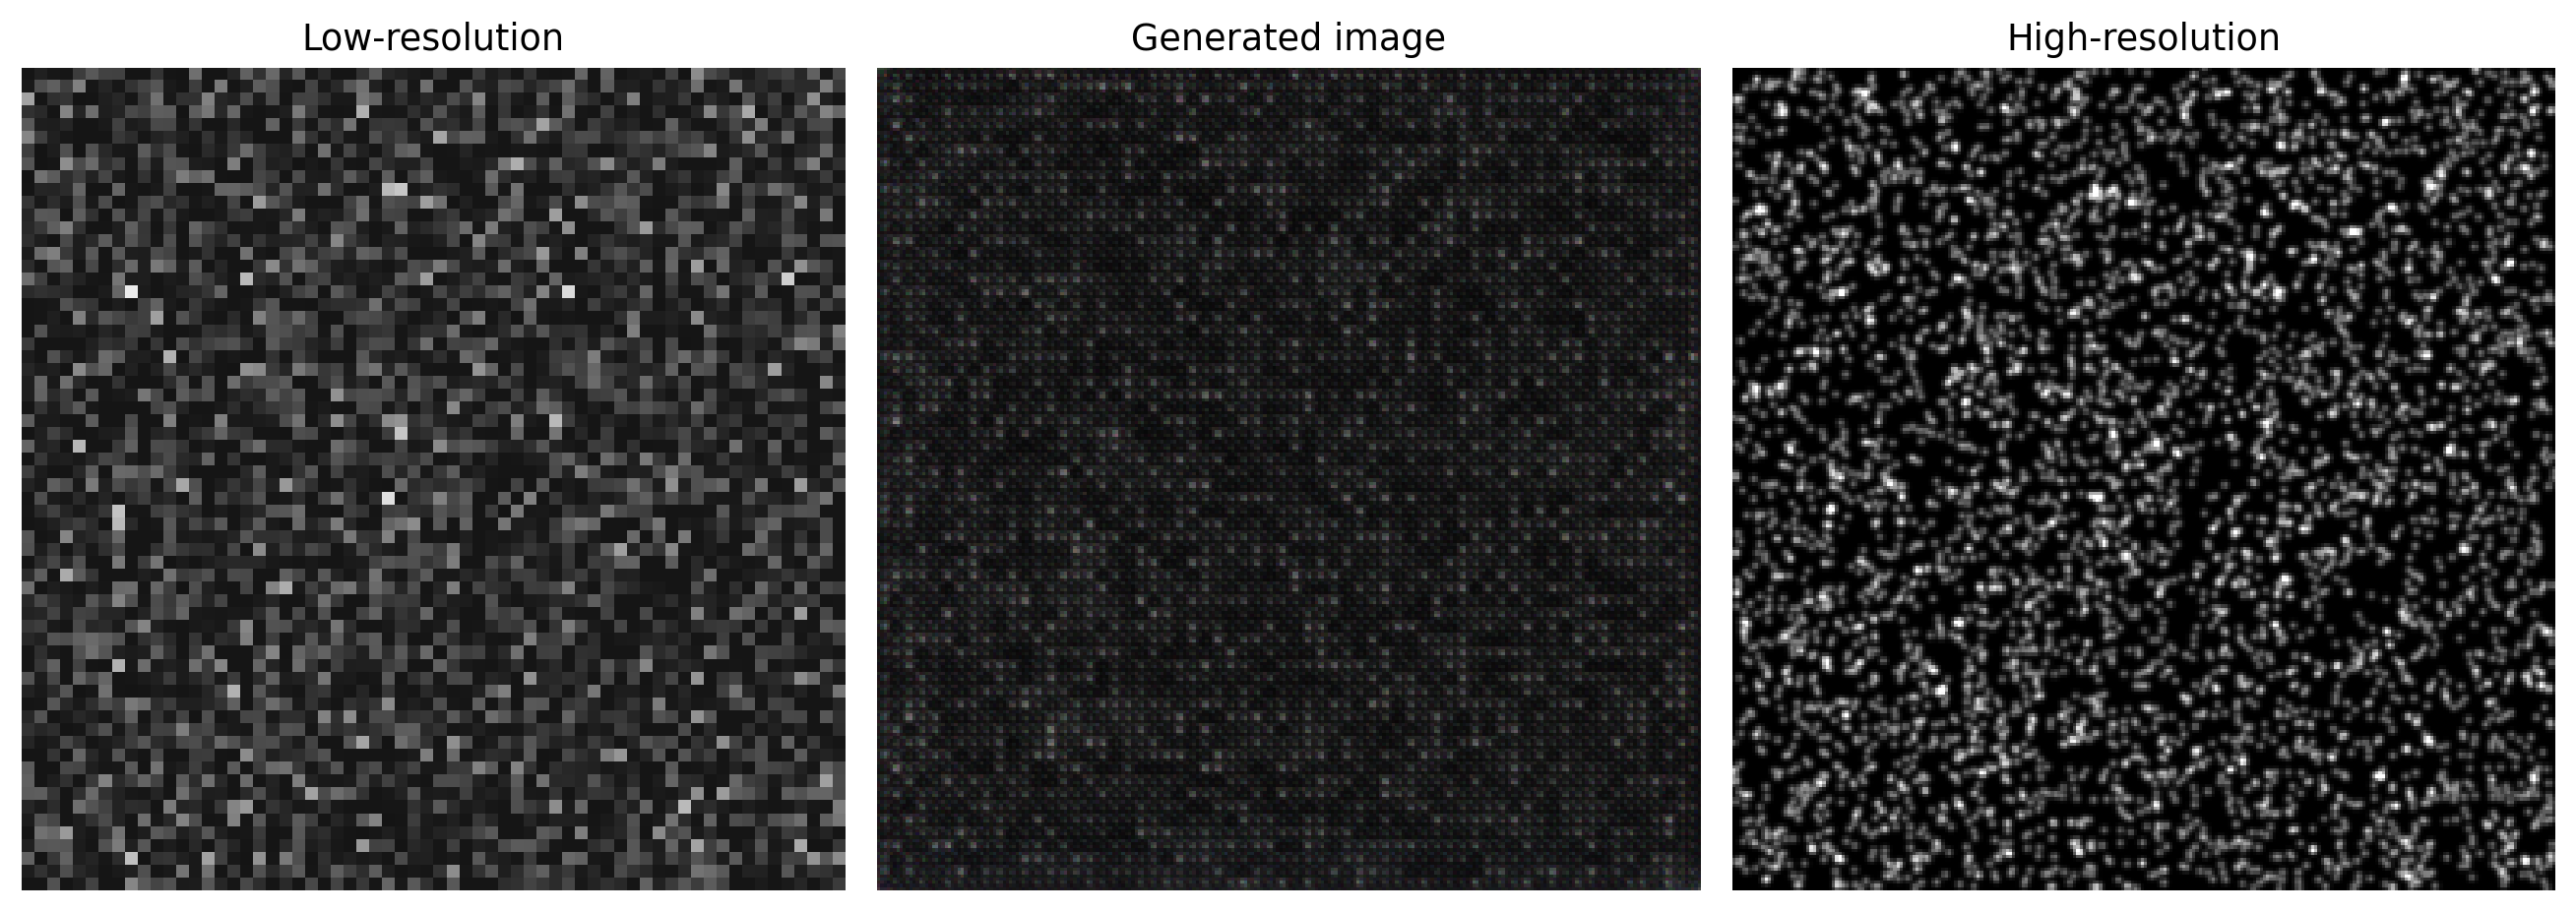

250/250 [==============================] - 333s 1s/step - d_loss: 0.6917 - g_loss: 0.3611
Epoch 3/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6902 - g_loss: 0.3527

<Figure size 640x480 with 0 Axes>

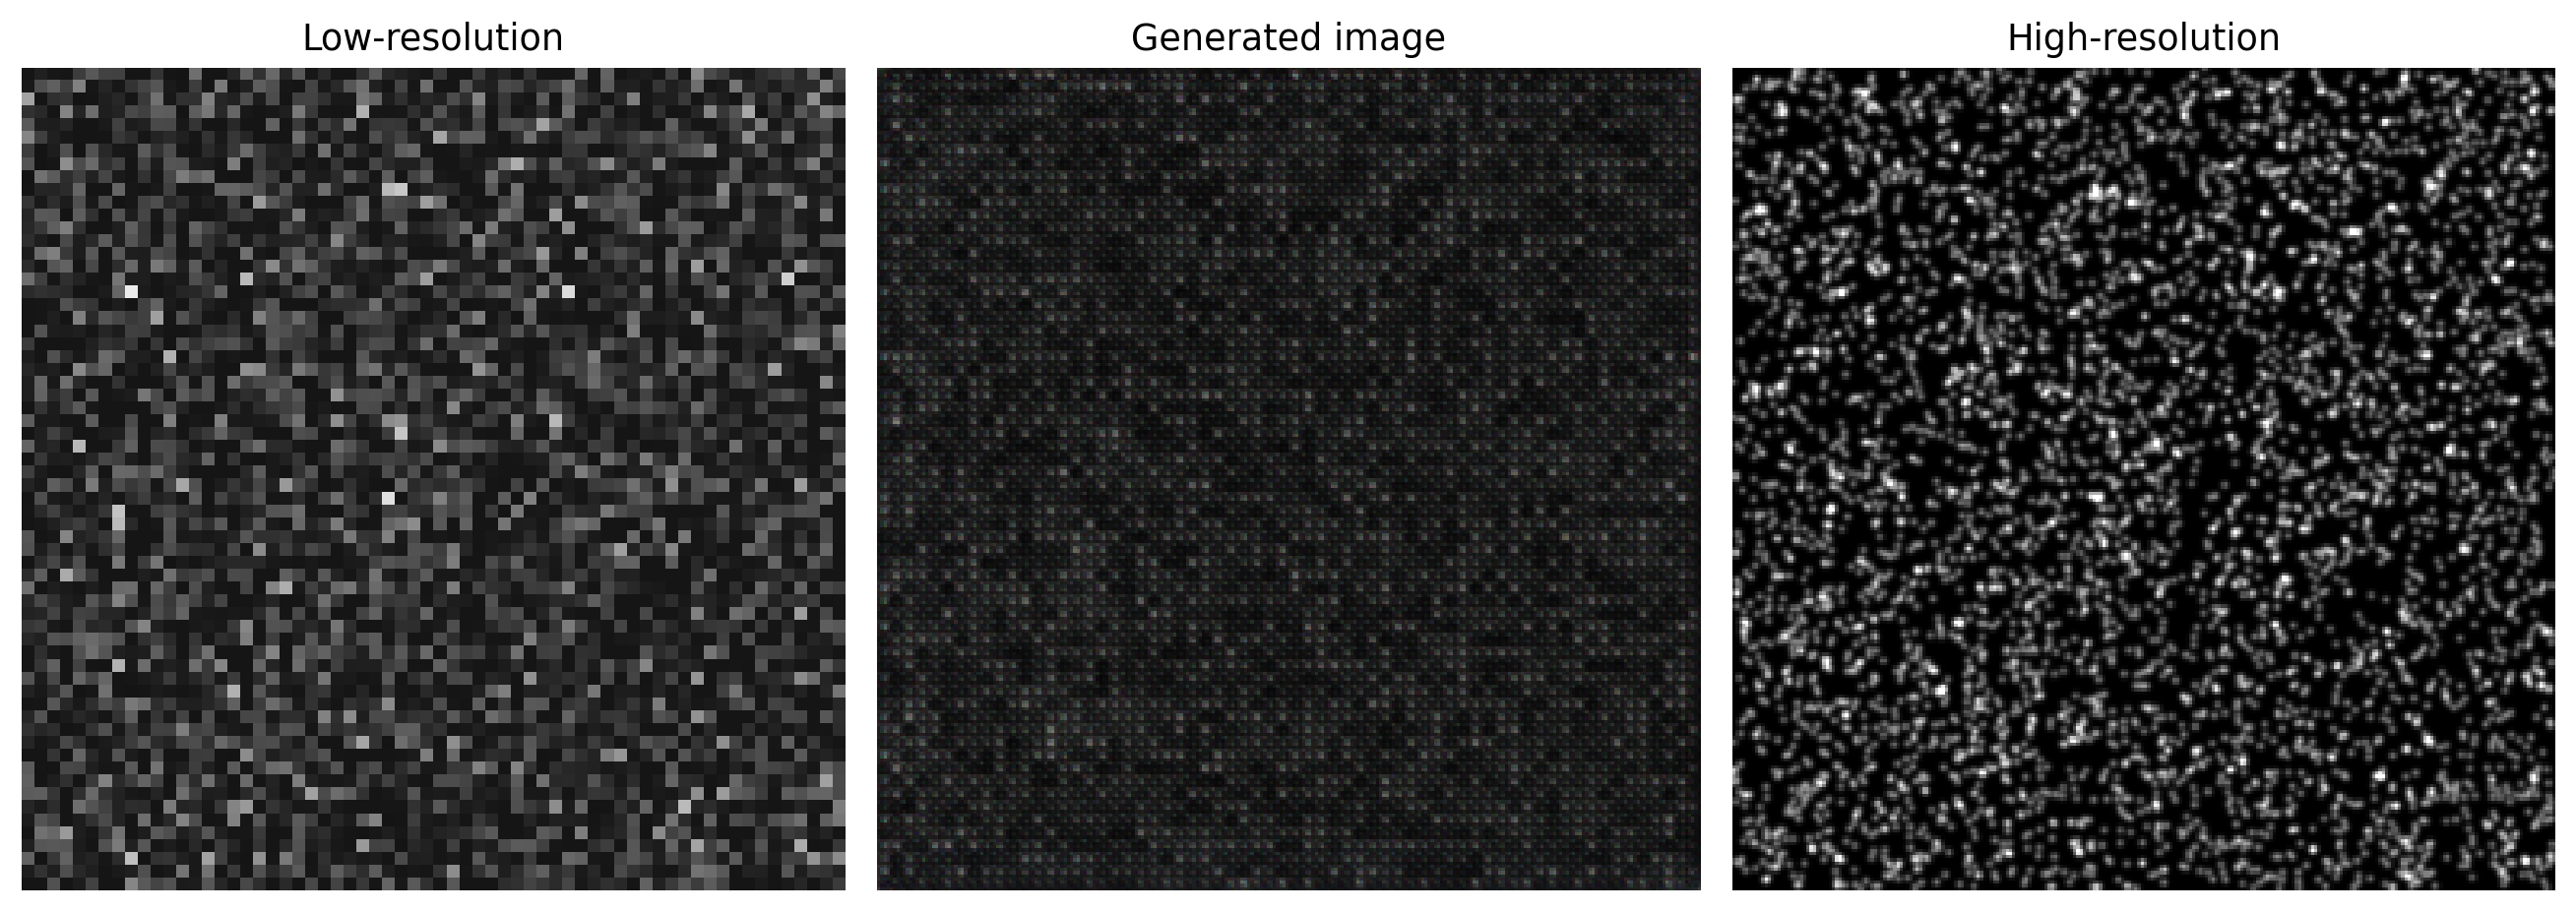

250/250 [==============================] - 334s 1s/step - d_loss: 0.6902 - g_loss: 0.3527
Epoch 4/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6884 - g_loss: 0.3477

<Figure size 640x480 with 0 Axes>

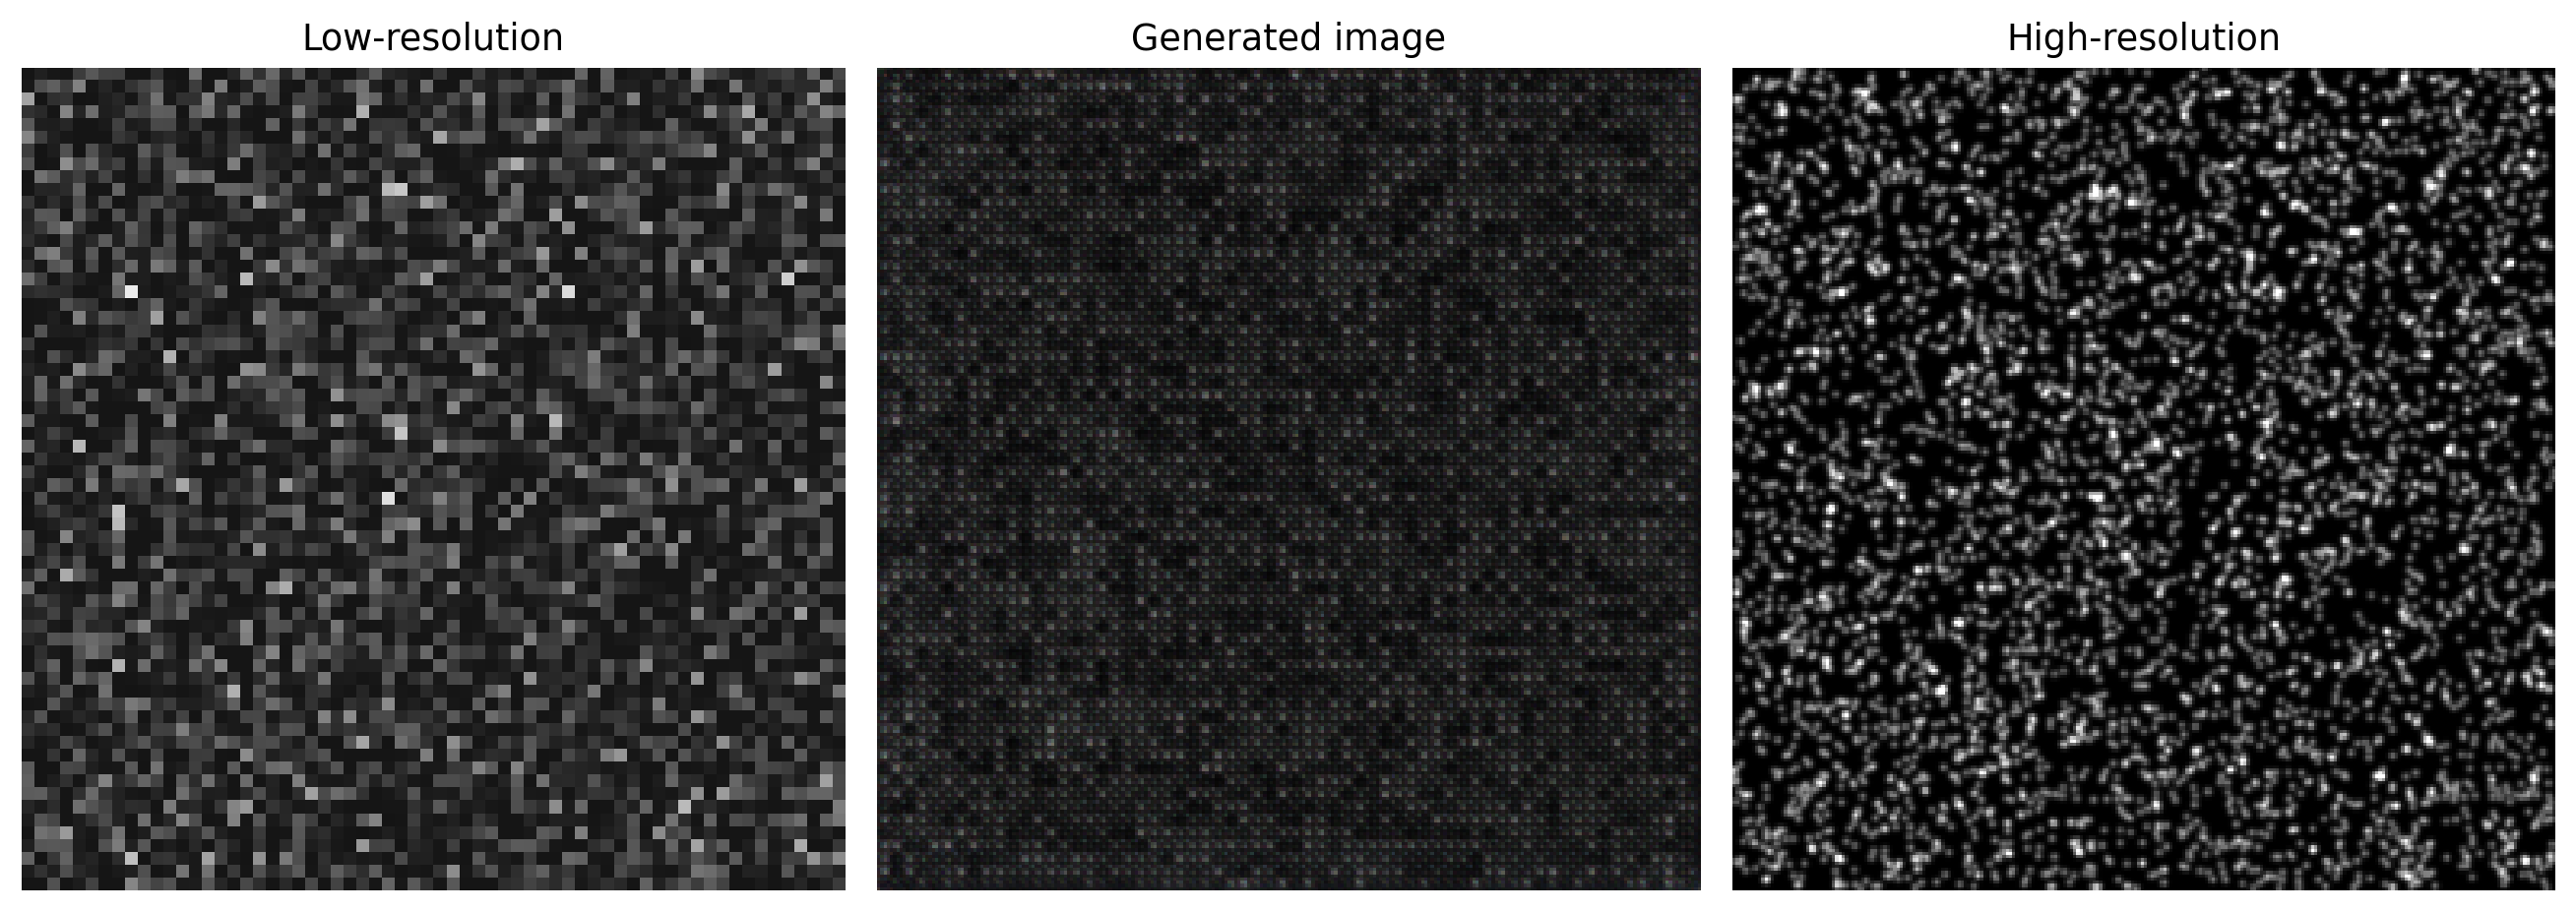

250/250 [==============================] - 334s 1s/step - d_loss: 0.6884 - g_loss: 0.3477
Epoch 5/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6859 - g_loss: 0.3448

<Figure size 640x480 with 0 Axes>

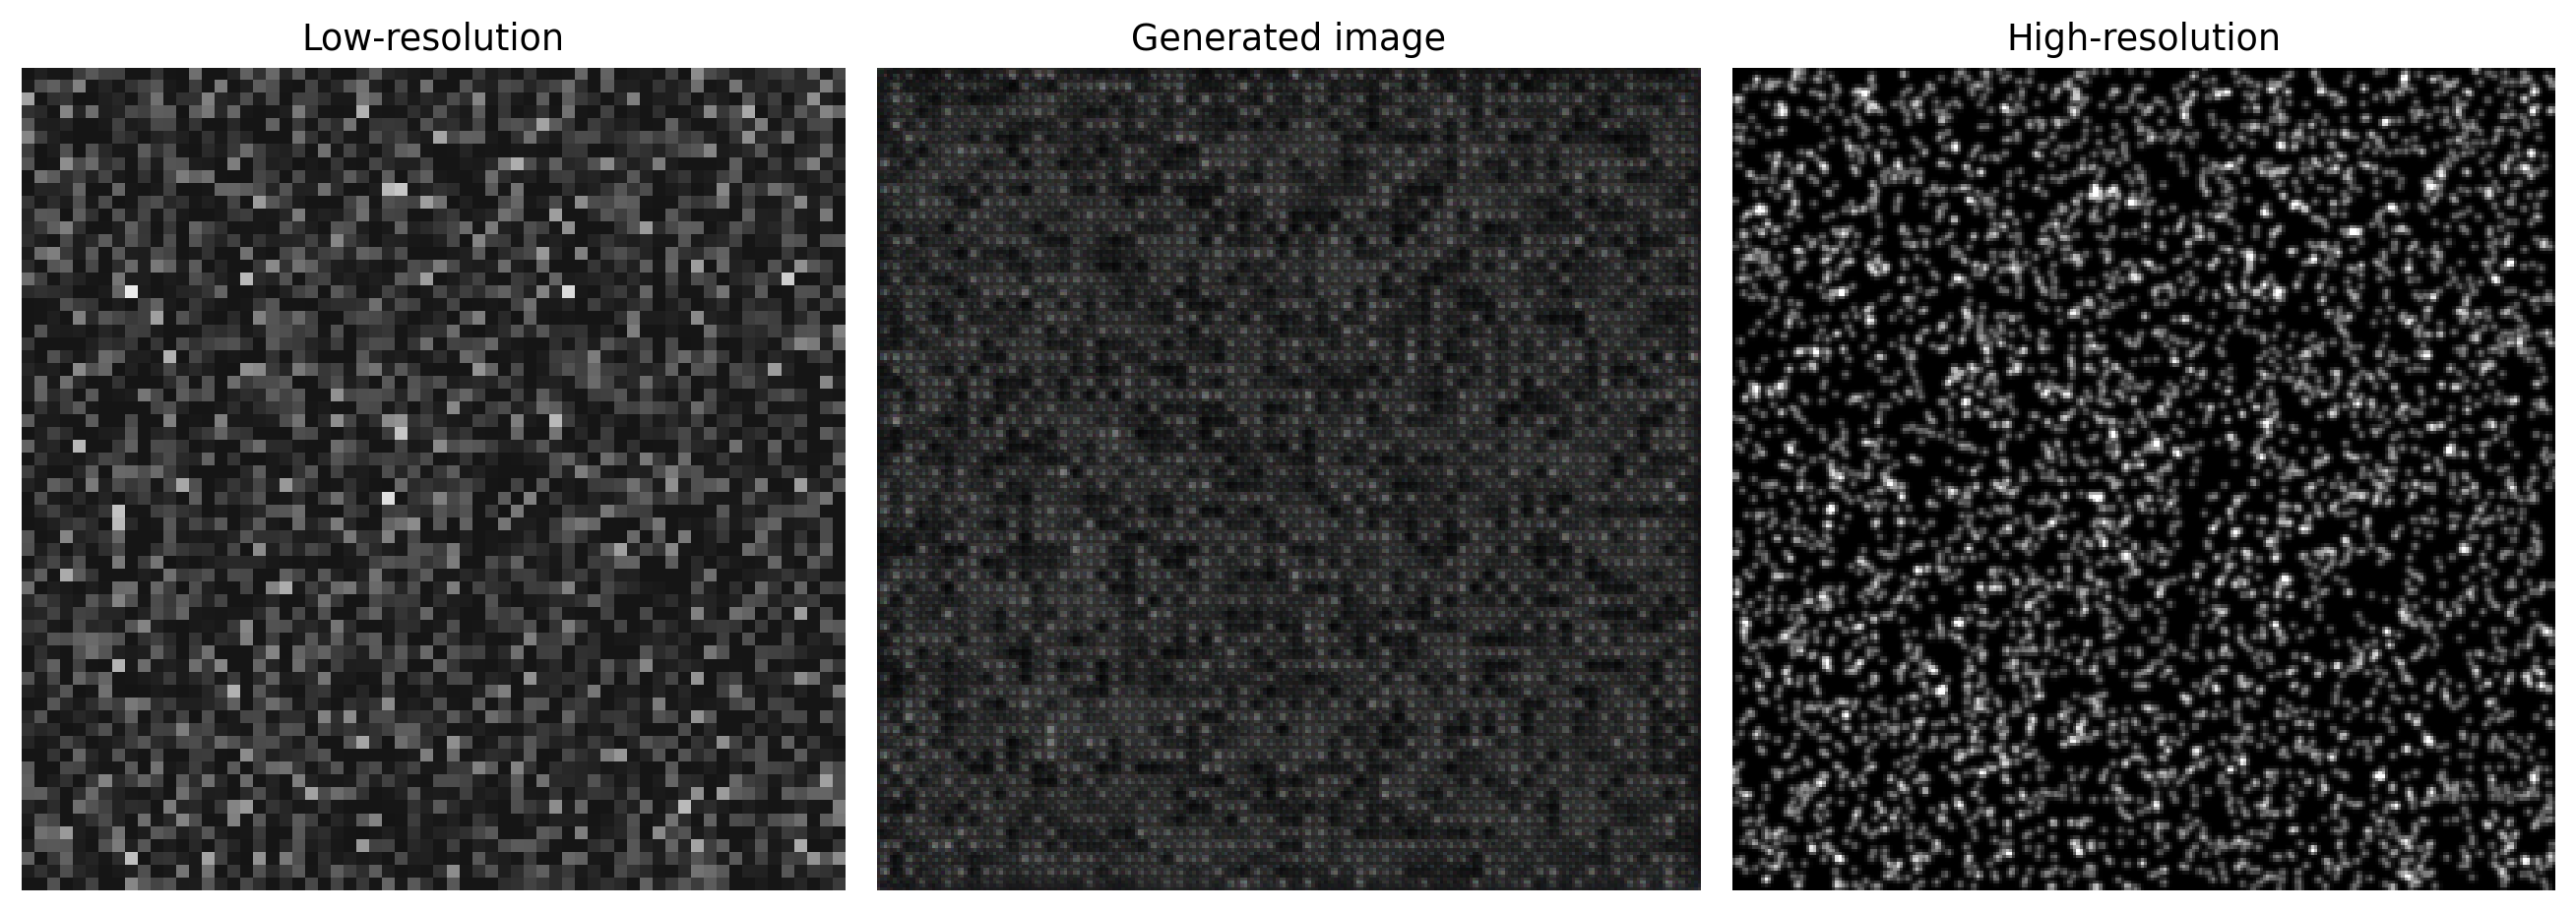

250/250 [==============================] - 334s 1s/step - d_loss: 0.6859 - g_loss: 0.3448
Epoch 6/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6824 - g_loss: 0.3421

<Figure size 640x480 with 0 Axes>

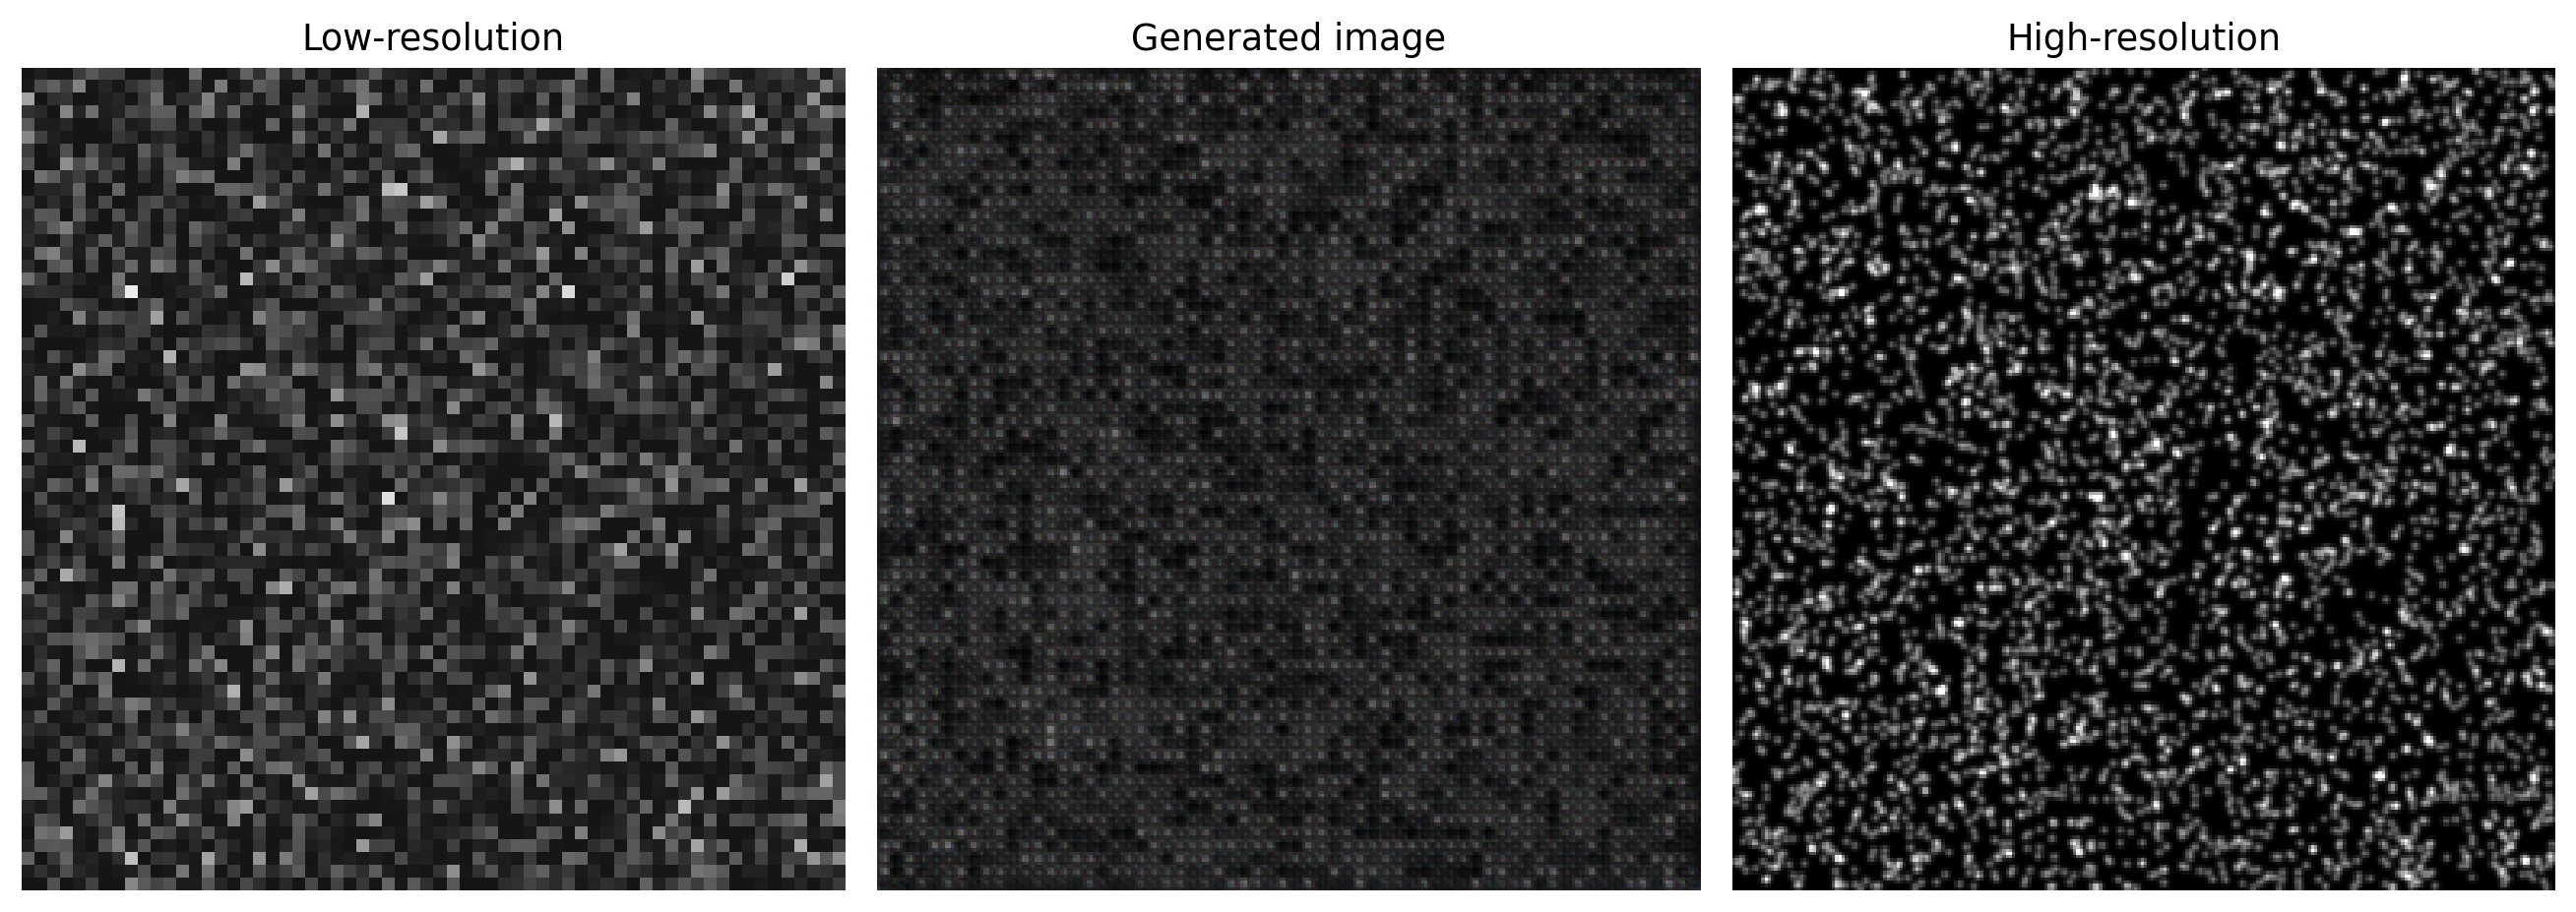

250/250 [==============================] - 334s 1s/step - d_loss: 0.6824 - g_loss: 0.3421
Epoch 7/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6776 - g_loss: 0.3398

<Figure size 640x480 with 0 Axes>

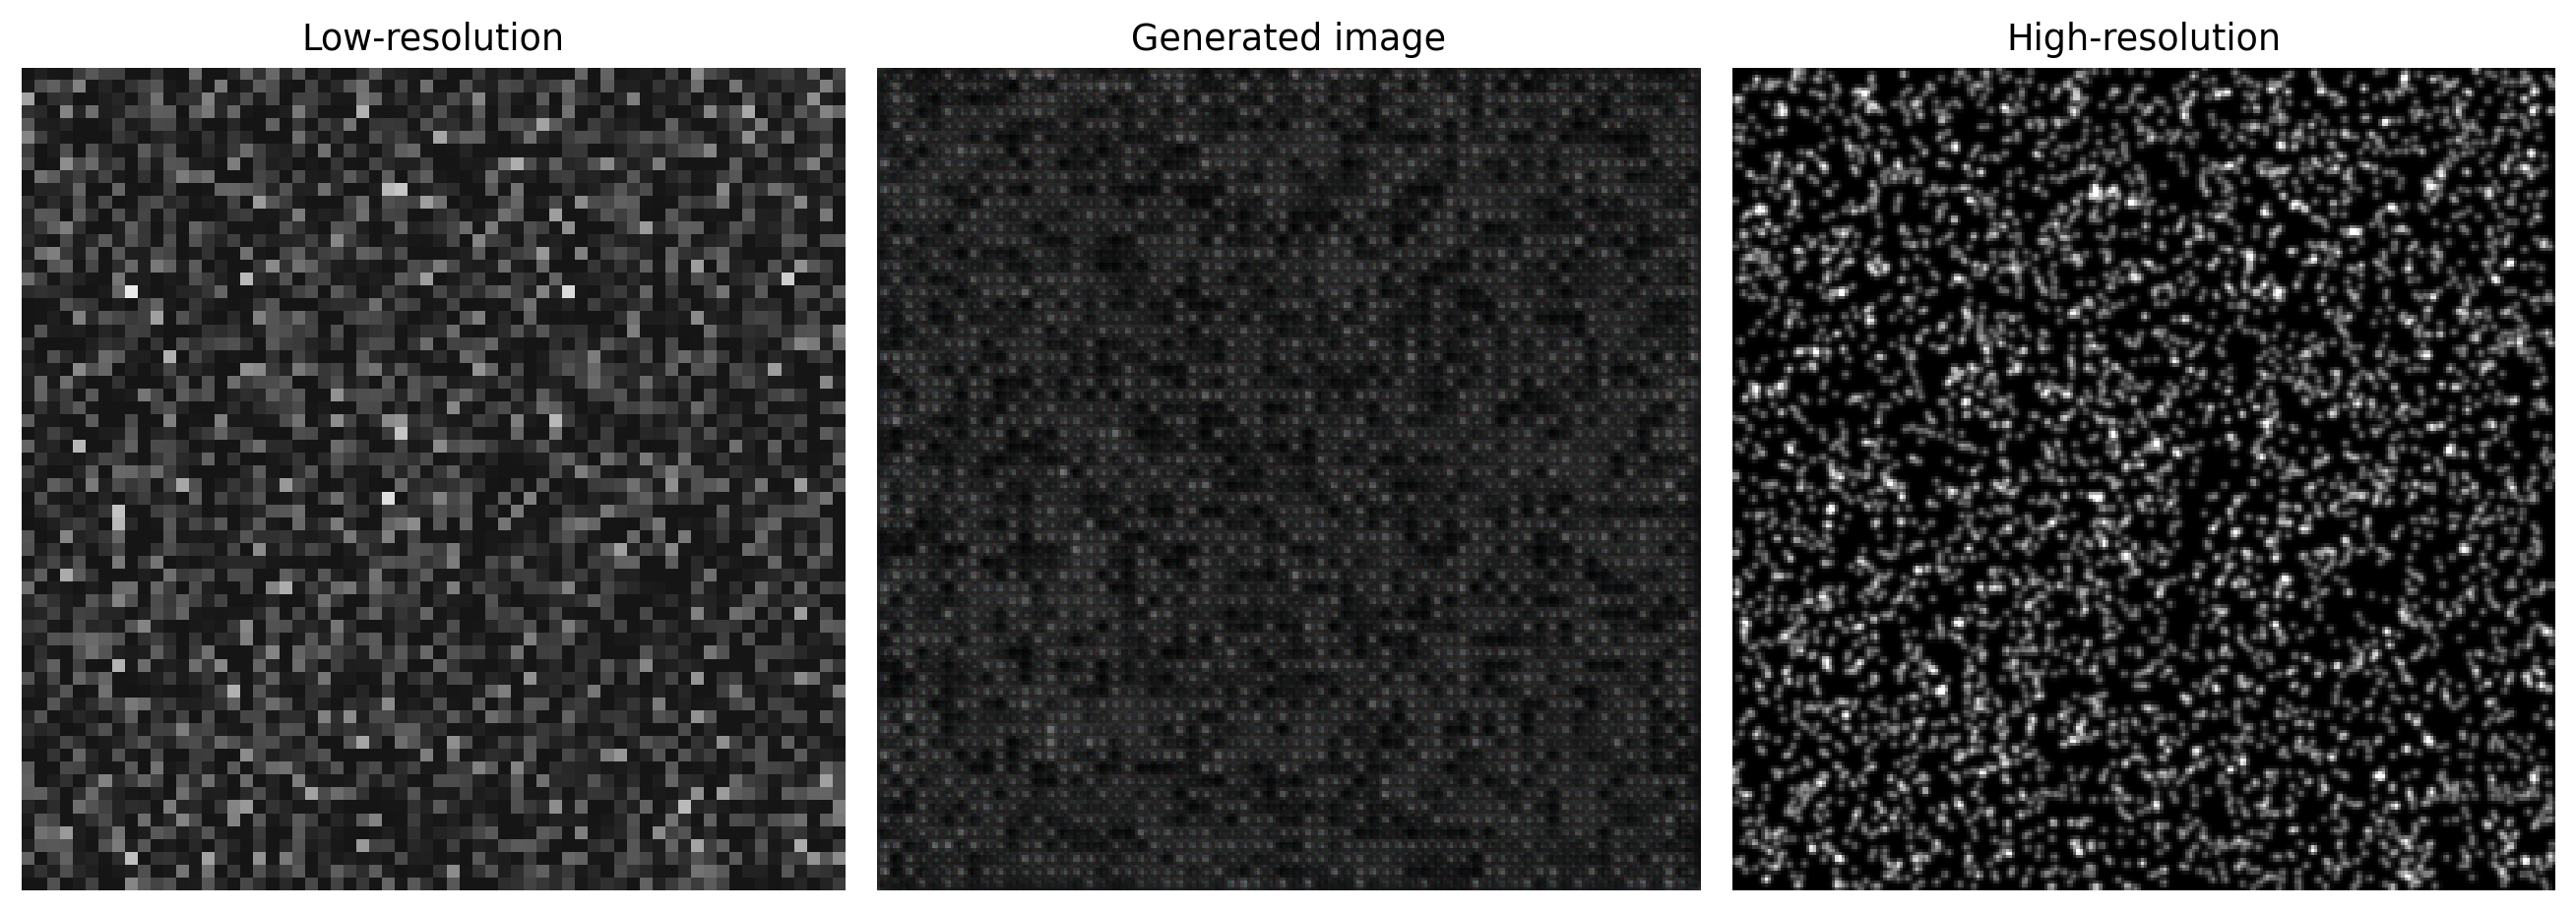

250/250 [==============================] - 334s 1s/step - d_loss: 0.6776 - g_loss: 0.3398
Epoch 8/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6715 - g_loss: 0.3383

<Figure size 640x480 with 0 Axes>

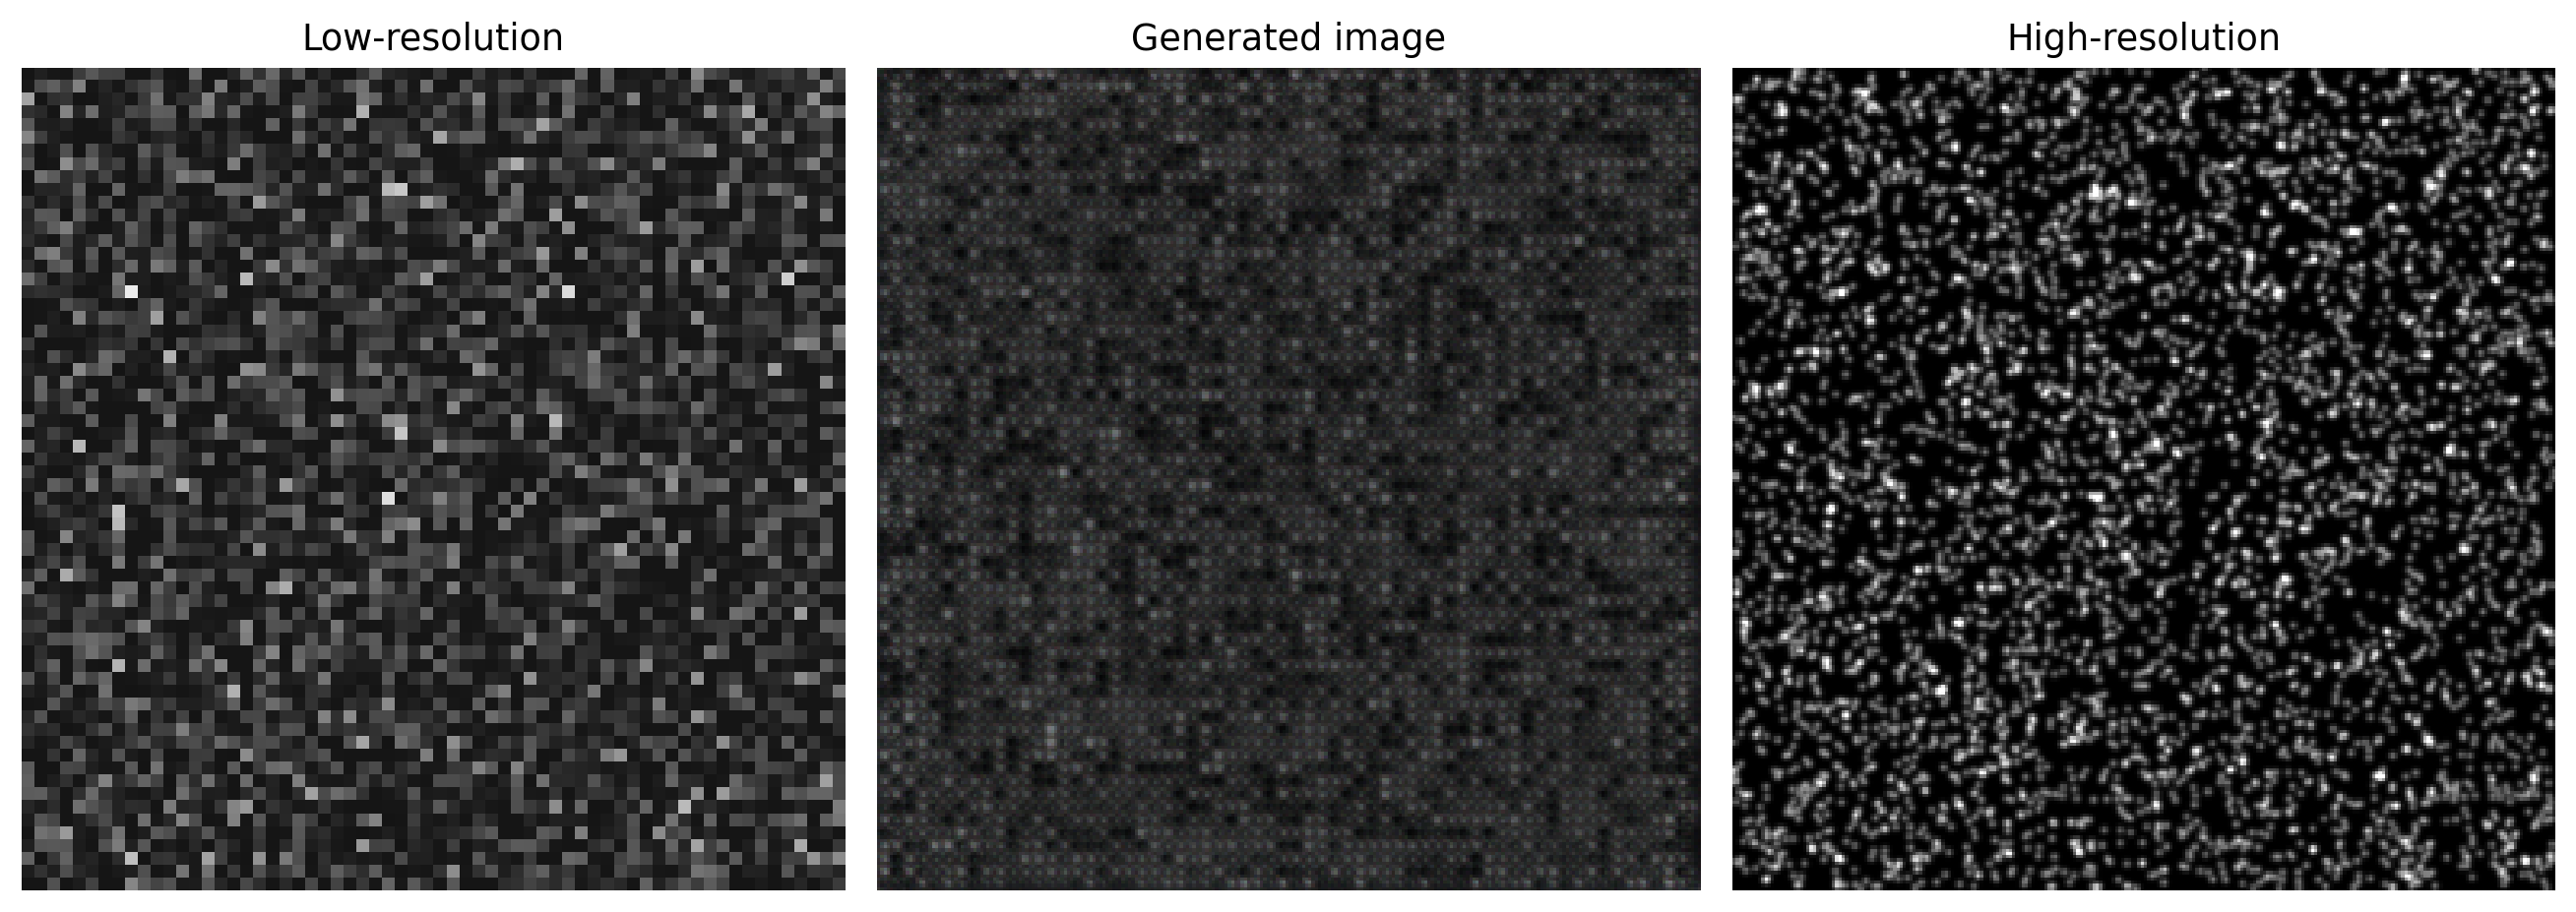

250/250 [==============================] - 334s 1s/step - d_loss: 0.6715 - g_loss: 0.3383
Epoch 9/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6634 - g_loss: 0.3368

<Figure size 640x480 with 0 Axes>

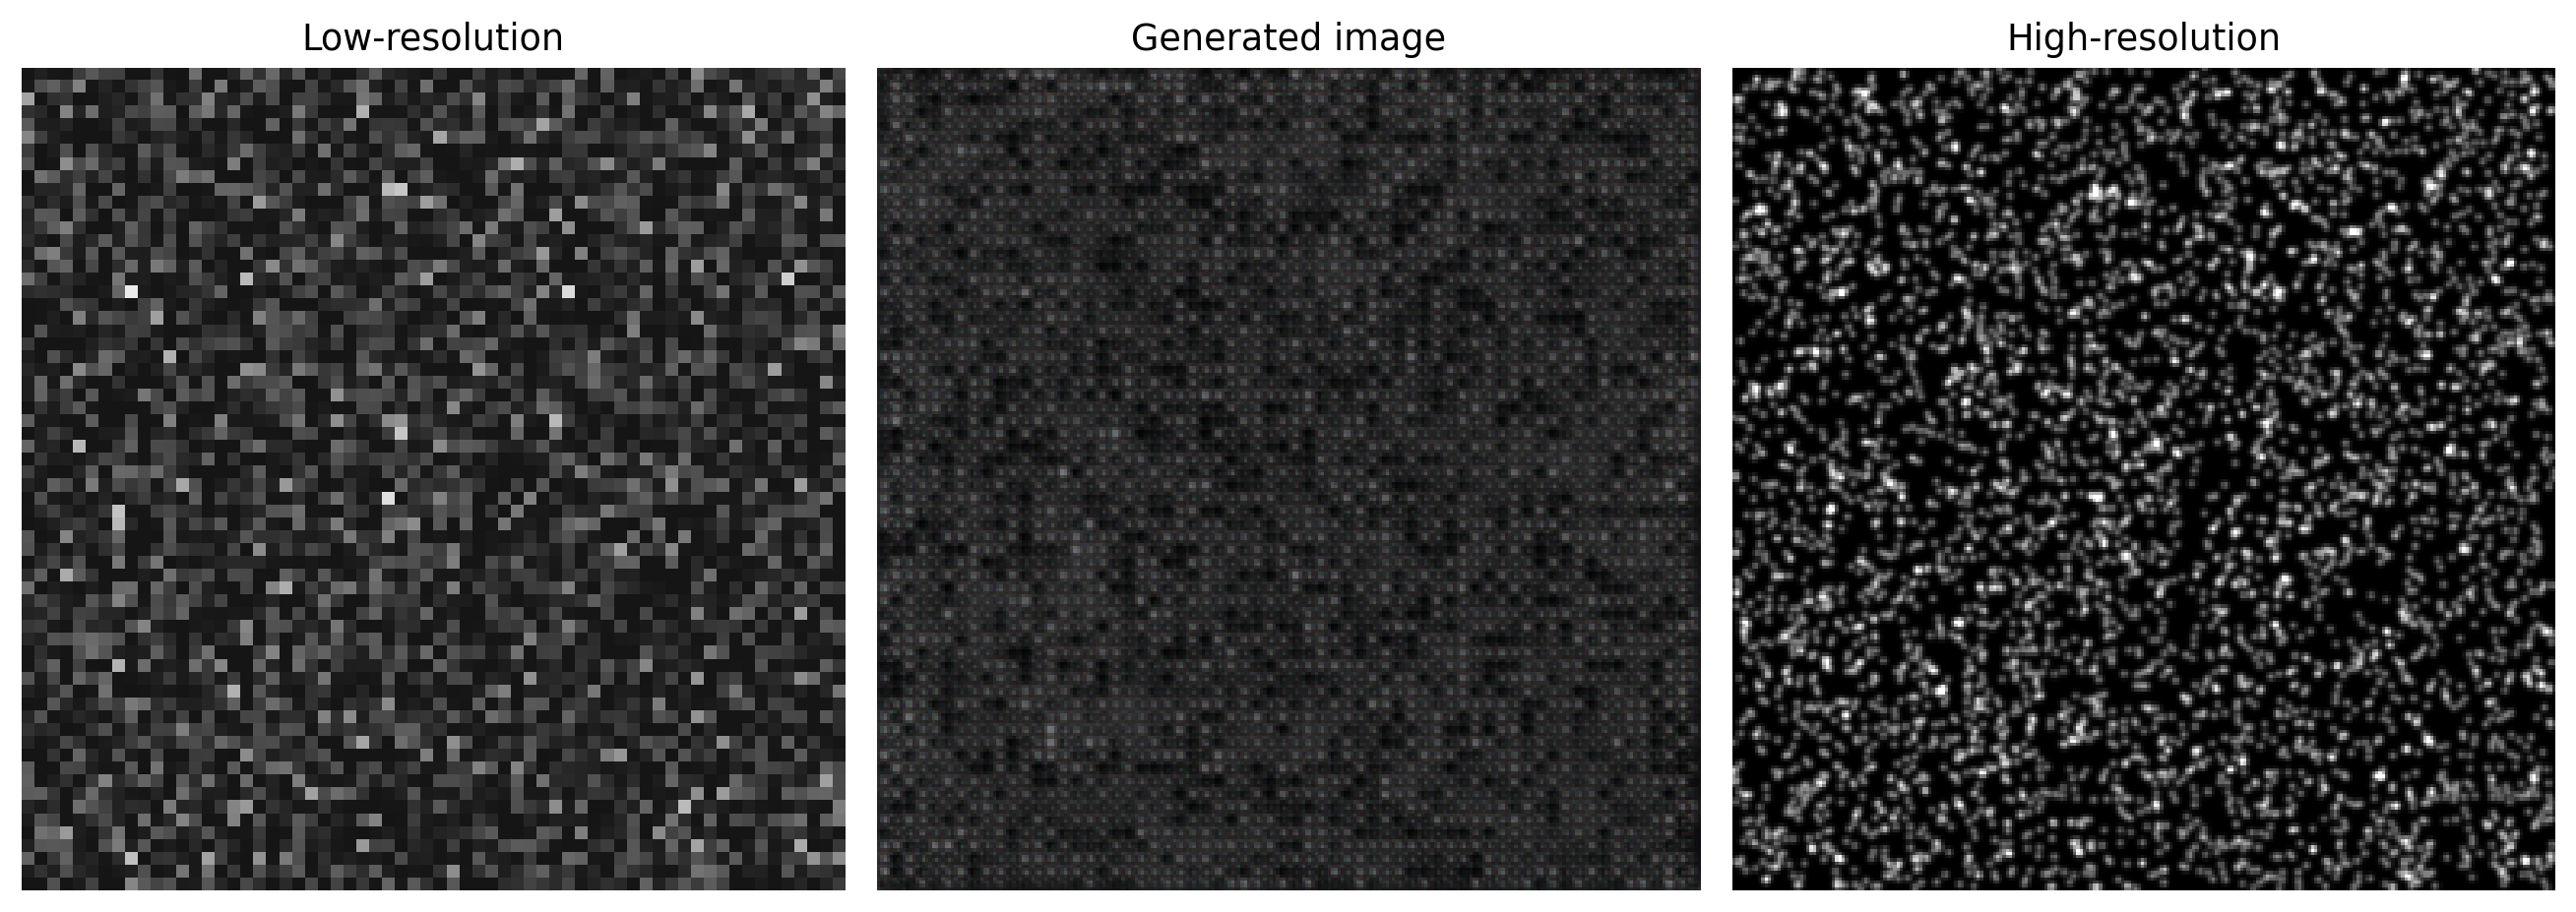

250/250 [==============================] - 333s 1s/step - d_loss: 0.6634 - g_loss: 0.3368
Epoch 10/10
250/250 [==============================] - ETA: 0s - d_loss: 0.6530 - g_loss: 0.3361

<Figure size 640x480 with 0 Axes>

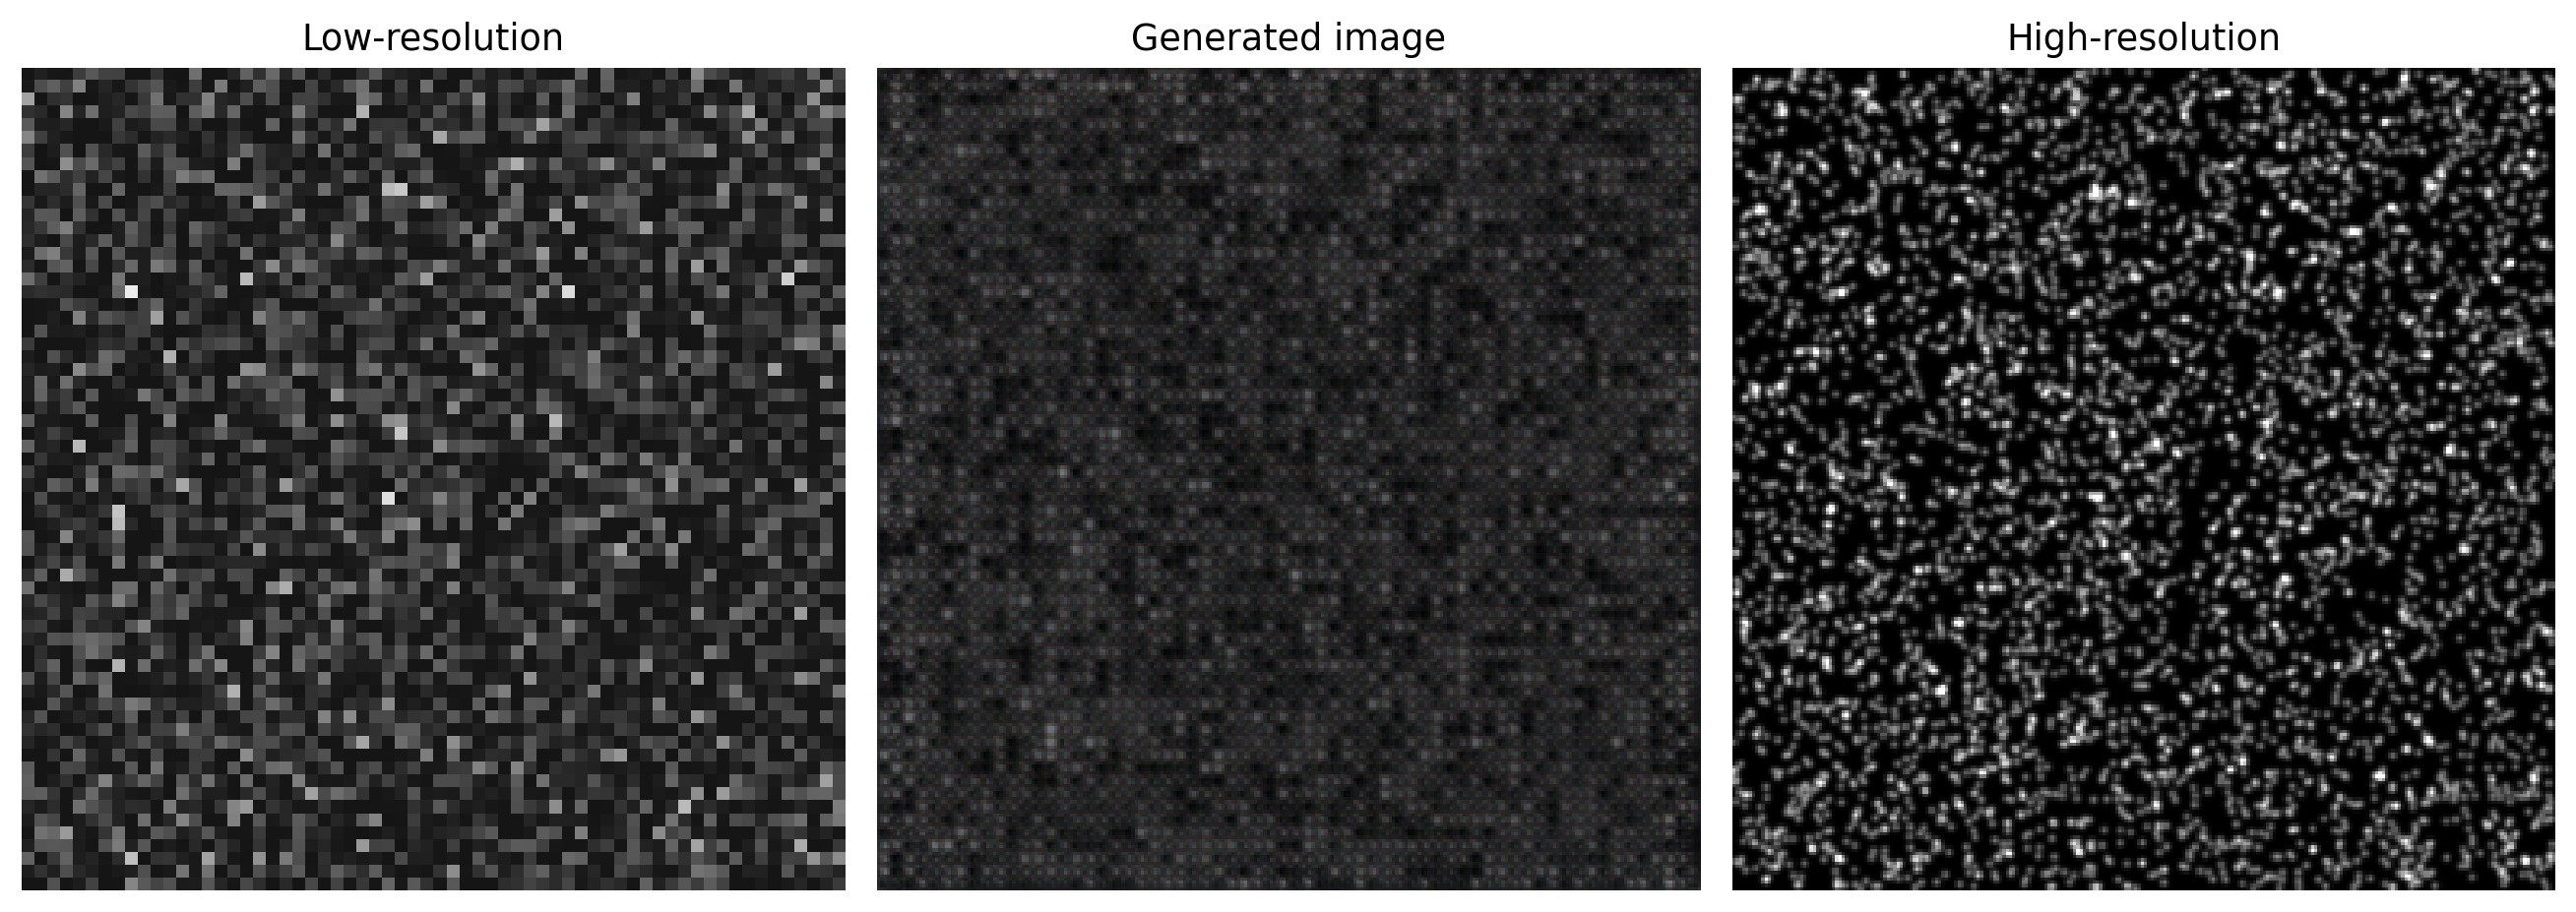

250/250 [==============================] - 333s 1s/step - d_loss: 0.6530 - g_loss: 0.3361


<Figure size 640x480 with 0 Axes>

In [28]:
history=srgan.fit(train_dataset,
                  epochs=epochs,
                  callbacks=[GANMonitor()])